In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Unins

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Encoder

In [4]:
class PointNetPPEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(PointNetPPEncoder, self).__init__()
        self.latent_dim = latent_dim

        # Shared MLPs for local feature extraction
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 256, 1)
        self.conv4 = nn.Conv1d(256, 512, 1)
        self.conv5 = nn.Conv1d(512, 1024, 1)
        self.conv6 = nn.Conv1d(1024, 2048, 1)

        # Fully connected layers for global features
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)       # Mean of latent distribution
        self.fc_log_sigma = nn.Linear(256, latent_dim)  # Log variance of latent distribution

    def forward(self, x):
        # Input x: (batch_size, num_points, 3)
        x = x.permute(0, 2, 1)  # Change to (batch_size, 3, num_points)

        # Apply shared MLPs
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        # Global max pooling
        x = torch.max(x, dim=2)[0]  # (batch_size, 256)

        # Fully connected layers for latent representation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        mu = self.fc_mu(x)           # (batch_size, latent_dim)
        log_sigma = self.fc_log_sigma(x)  # (batch_size, latent_dim)
        return mu, log_sigma

Decoder

In [5]:
class PointNetPPDecoder(nn.Module):
    def __init__(self, latent_dim=128, num_points=4096):
        super(PointNetPPDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.num_points = num_points

        # Fully connected layers to create an initial coarse point cloud
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)  # Coarse point cloud (e.g., 256 points * 3)

        # Upsampling layers for finer details
        self.fc4 = nn.Linear(1024, 2048)
        self.fc5 = nn.Linear(2048, 4096)
        self.fc6 = nn.Linear(4096, num_points * 3) # Final high-resolution output

    def forward(self, z):
        # Input z: (batch_size, latent_dim)
        x = F.relu(self.fc1(z))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))  # Coarse point cloud

        # Upsample to finer resolution
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)  # (batch_size, num_points * 3)

        # Reshape to point cloud format
        x = x.view(-1, self.num_points, 3)  # (batch_size, num_points, 3)
        return x

Reparameterization trick

In [6]:
def reparameterize(mu, log_sigma):
    """
    Reparameterization trick to sample latent variable z.
    z = mu + eps * exp(log_sigma * 0.5)
    """
    std = torch.exp(0.5 * log_sigma)
    epsilon = torch.randn_like(std)
    return mu + epsilon * std

Encoder + Decoder + Reparameterization Trick = Autoencoder (in our case, Variational Autoencoder because we have mu and log sigma)

In [7]:
class PointNetPPAutoencoder(nn.Module):
    def __init__(self, latent_dim=128, num_points=4096):
        super(PointNetPPAutoencoder, self).__init__()
        self.encoder = PointNetPPEncoder(latent_dim)
        self.decoder = PointNetPPDecoder(latent_dim, num_points)

    def forward(self, x):
        """
        Returns:
          reconstructed: (batch_size, num_points, 3)
          mu: (batch_size, latent_dim)
          log_sigma: (batch_size, latent_dim)
        """
        mu, log_sigma = self.encoder(x)
        z = reparameterize(mu, log_sigma)  # <-- Use the reparam trick
        reconstructed = self.decoder(z)
        return reconstructed, mu, log_sigma

Loss Functions

In [8]:
def chamfer_distance(x, y):
    """
    Compute Chamfer Distance between two point clouds x and y.
    """
    x_expanded = x.unsqueeze(2)  # (batch_size, num_points_x, 1, 3)
    y_expanded = y.unsqueeze(1)  # (batch_size, 1, num_points_y, 3)
    distances = torch.norm(x_expanded - y_expanded, dim=3)  # Pairwise distances
    min_dist_x = torch.min(distances, dim=2)[0]
    min_dist_y = torch.min(distances, dim=1)[0]
    return torch.mean(min_dist_x) + torch.mean(min_dist_y)

def kl_divergence(mu, log_sigma):
    """
    Compute the KL divergence between the encoder's latent distribution and a standard Gaussian.
    Args:
        mu: Mean of the latent distribution (batch_size, latent_dim)
        log_sigma: Log of standard deviation (batch_size, latent_dim)
    Returns:
        kl_loss: The KL divergence loss (scalar)
    """
    kl_loss = -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - log_sigma.exp(), dim=1)
    return torch.mean(kl_loss)  # Return the batch mean

In [9]:
import torch
import torch.utils.data as data
import open3d as o3d
import os
import numpy as np
from torch.utils.data import random_split

class PointCloudDataset(data.Dataset):
    def __init__(self, folder_path, num_points=4096):
        self.folder_path = folder_path
        self.num_points = num_points
        self.files = [f for f in os.listdir(folder_path) if f.endswith('.ply')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, self.files[idx])
        pcd = o3d.io.read_point_cloud(file_path)
        points = np.asarray(pcd.points)

        # Scale and center the point cloud to fit within a unit cube or sphere:
        points -= np.mean(points, axis=0)  # Center
        # points /= np.max(np.linalg.norm(points, axis=1))  # I chose not to scale since I would like to see if my latent space can predict for height

        # Randomly sample or pad points to ensure uniformity
        if points.shape[0] > self.num_points:
            indices = np.random.choice(points.shape[0], self.num_points, replace=False)
            points = points[indices]
        elif points.shape[0] < self.num_points:
            pad_size = self.num_points - points.shape[0]
            pad_points = np.zeros((pad_size, 3))
            points = np.vstack((points, pad_points))

        return torch.tensor(points, dtype=torch.float32)


Data Loader

In [10]:
import torch
from torch.utils.data import random_split

def get_data_loaders(folder_path="/content/drive/MyDrive/buildings_pointcloud_ply",
                     num_points=4096,
                     batch_size=32,
                     train_ratio=0.9,
                     random_seed=42):  # Added a seed parameter for reproducibility
    # Set the random seed for reproducibility
    torch.manual_seed(random_seed)

    dataset = PointCloudDataset(folder_path, num_points=num_points)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Dataset split: {len(train_dataset)} train samples, {len(test_dataset)} test samples")
    return train_loader, test_loader



Define Training Loop

In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim

def train_model(folder_path="/content/drive/MyDrive/buildings_pointcloud_ply",
                latent_dim=128,
                num_points=4096,
                batch_size=16,
                num_epochs=50,
                learning_rate=0.001,
                beta=1.0,
                device="cpu"):

    # Prepare data
    train_loader, test_loader = get_data_loaders(
        folder_path=folder_path,
        num_points=num_points,
        batch_size=batch_size,
        train_ratio=0.9
    )

    # Initialize model
    model = PointNetPPAutoencoder(latent_dim=latent_dim, num_points=num_points)
    model.to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = []

    print("Starting training...")
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

        for batch in progress_bar:
            batch = batch.to(device)

            optimizer.zero_grad()

            # Forward pass (with VAE components)
            reconstructed, mu, log_sigma = model(batch)

            # Compute losses
            recon_loss = chamfer_distance(reconstructed, batch)
            kld_loss = kl_divergence(mu, log_sigma)

            # Total loss (VAE) (which is equal to B=1)
            # loss = recon_loss + kld_loss

            # Total loss (beta-VAE)
            loss = recon_loss + beta * kld_loss

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix({"Batch Loss": loss.item()})

        avg_epoch_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_epoch_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")

        # Save the trained model
        model_save_path = "pointnetpp_B3-VAE.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")



    # Plot loss history
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), loss_history, marker='o', linestyle='-')
    plt.title("Training Loss Over Epochs (Chamfer + KL)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

Train

Dataset split: 3606 train samples, 401 test samples
Starting training...


Epoch 1/50: 100%|██████████| 226/226 [02:22<00:00,  1.59it/s, Batch Loss=6.21]


Epoch 1/50, Loss: 5.6576
Model saved to pointnetpp_B3-VAE.pth


Epoch 2/50: 100%|██████████| 226/226 [00:26<00:00,  8.68it/s, Batch Loss=6.98]


Epoch 2/50, Loss: 5.2378
Model saved to pointnetpp_B3-VAE.pth


Epoch 3/50: 100%|██████████| 226/226 [00:26<00:00,  8.39it/s, Batch Loss=9.28]


Epoch 3/50, Loss: 5.2100
Model saved to pointnetpp_B3-VAE.pth


Epoch 4/50: 100%|██████████| 226/226 [00:26<00:00,  8.42it/s, Batch Loss=12.5]


Epoch 4/50, Loss: 5.1692
Model saved to pointnetpp_B3-VAE.pth


Epoch 5/50: 100%|██████████| 226/226 [00:26<00:00,  8.42it/s, Batch Loss=3.81]


Epoch 5/50, Loss: 5.1355
Model saved to pointnetpp_B3-VAE.pth


Epoch 6/50: 100%|██████████| 226/226 [00:26<00:00,  8.42it/s, Batch Loss=5.63]


Epoch 6/50, Loss: 5.1267
Model saved to pointnetpp_B3-VAE.pth


Epoch 7/50: 100%|██████████| 226/226 [00:26<00:00,  8.41it/s, Batch Loss=6.39]


Epoch 7/50, Loss: 5.1264
Model saved to pointnetpp_B3-VAE.pth


Epoch 8/50: 100%|██████████| 226/226 [00:26<00:00,  8.47it/s, Batch Loss=4.63]


Epoch 8/50, Loss: 5.1023
Model saved to pointnetpp_B3-VAE.pth


Epoch 9/50: 100%|██████████| 226/226 [00:26<00:00,  8.51it/s, Batch Loss=3.42]


Epoch 9/50, Loss: 5.1028
Model saved to pointnetpp_B3-VAE.pth


Epoch 10/50: 100%|██████████| 226/226 [00:26<00:00,  8.47it/s, Batch Loss=3.55]


Epoch 10/50, Loss: 5.0787
Model saved to pointnetpp_B3-VAE.pth


Epoch 11/50: 100%|██████████| 226/226 [00:26<00:00,  8.41it/s, Batch Loss=3.39]


Epoch 11/50, Loss: 5.0872
Model saved to pointnetpp_B3-VAE.pth


Epoch 12/50: 100%|██████████| 226/226 [00:26<00:00,  8.47it/s, Batch Loss=3.94]


Epoch 12/50, Loss: 5.0766
Model saved to pointnetpp_B3-VAE.pth


Epoch 13/50: 100%|██████████| 226/226 [00:26<00:00,  8.40it/s, Batch Loss=5.47]


Epoch 13/50, Loss: 5.0756
Model saved to pointnetpp_B3-VAE.pth


Epoch 14/50: 100%|██████████| 226/226 [00:26<00:00,  8.44it/s, Batch Loss=3.71]


Epoch 14/50, Loss: 5.0678
Model saved to pointnetpp_B3-VAE.pth


Epoch 15/50: 100%|██████████| 226/226 [00:26<00:00,  8.50it/s, Batch Loss=6.33]


Epoch 15/50, Loss: 5.0752
Model saved to pointnetpp_B3-VAE.pth


Epoch 16/50: 100%|██████████| 226/226 [00:26<00:00,  8.47it/s, Batch Loss=3.76]


Epoch 16/50, Loss: 5.0695
Model saved to pointnetpp_B3-VAE.pth


Epoch 17/50: 100%|██████████| 226/226 [00:26<00:00,  8.49it/s, Batch Loss=3.73]


Epoch 17/50, Loss: 5.0559
Model saved to pointnetpp_B3-VAE.pth


Epoch 18/50: 100%|██████████| 226/226 [00:26<00:00,  8.52it/s, Batch Loss=3.83]


Epoch 18/50, Loss: 5.0558
Model saved to pointnetpp_B3-VAE.pth


Epoch 19/50: 100%|██████████| 226/226 [00:26<00:00,  8.43it/s, Batch Loss=3.05]


Epoch 19/50, Loss: 5.0619
Model saved to pointnetpp_B3-VAE.pth


Epoch 20/50: 100%|██████████| 226/226 [00:26<00:00,  8.46it/s, Batch Loss=3.67]


Epoch 20/50, Loss: 5.0536
Model saved to pointnetpp_B3-VAE.pth


Epoch 21/50: 100%|██████████| 226/226 [00:26<00:00,  8.50it/s, Batch Loss=3.38]


Epoch 21/50, Loss: 5.0555
Model saved to pointnetpp_B3-VAE.pth


Epoch 22/50: 100%|██████████| 226/226 [00:26<00:00,  8.48it/s, Batch Loss=5.38]


Epoch 22/50, Loss: 5.0551
Model saved to pointnetpp_B3-VAE.pth


Epoch 23/50: 100%|██████████| 226/226 [00:26<00:00,  8.50it/s, Batch Loss=5.24]


Epoch 23/50, Loss: 5.0560
Model saved to pointnetpp_B3-VAE.pth


Epoch 24/50: 100%|██████████| 226/226 [00:26<00:00,  8.47it/s, Batch Loss=3.11]


Epoch 24/50, Loss: 5.0502
Model saved to pointnetpp_B3-VAE.pth


Epoch 25/50: 100%|██████████| 226/226 [00:26<00:00,  8.54it/s, Batch Loss=3.4]


Epoch 25/50, Loss: 5.0461
Model saved to pointnetpp_B3-VAE.pth


Epoch 26/50: 100%|██████████| 226/226 [00:26<00:00,  8.50it/s, Batch Loss=4.97]


Epoch 26/50, Loss: 5.0510
Model saved to pointnetpp_B3-VAE.pth


Epoch 27/50: 100%|██████████| 226/226 [00:26<00:00,  8.48it/s, Batch Loss=5.05]


Epoch 27/50, Loss: 5.0480
Model saved to pointnetpp_B3-VAE.pth


Epoch 28/50: 100%|██████████| 226/226 [00:26<00:00,  8.46it/s, Batch Loss=5.24]


Epoch 28/50, Loss: 5.0463
Model saved to pointnetpp_B3-VAE.pth


Epoch 29/50: 100%|██████████| 226/226 [00:26<00:00,  8.49it/s, Batch Loss=5.97]


Epoch 29/50, Loss: 5.0530
Model saved to pointnetpp_B3-VAE.pth


Epoch 30/50: 100%|██████████| 226/226 [00:26<00:00,  8.54it/s, Batch Loss=4.01]


Epoch 30/50, Loss: 5.0462
Model saved to pointnetpp_B3-VAE.pth


Epoch 31/50: 100%|██████████| 226/226 [00:26<00:00,  8.46it/s, Batch Loss=15.5]


Epoch 31/50, Loss: 5.0761
Model saved to pointnetpp_B3-VAE.pth


Epoch 32/50: 100%|██████████| 226/226 [00:26<00:00,  8.59it/s, Batch Loss=3.14]


Epoch 32/50, Loss: 5.0390
Model saved to pointnetpp_B3-VAE.pth


Epoch 33/50: 100%|██████████| 226/226 [00:26<00:00,  8.42it/s, Batch Loss=2.88]


Epoch 33/50, Loss: 5.0381
Model saved to pointnetpp_B3-VAE.pth


Epoch 34/50: 100%|██████████| 226/226 [00:26<00:00,  8.42it/s, Batch Loss=3.82]


Epoch 34/50, Loss: 5.0442
Model saved to pointnetpp_B3-VAE.pth


Epoch 35/50: 100%|██████████| 226/226 [00:27<00:00,  8.37it/s, Batch Loss=3.42]


Epoch 35/50, Loss: 5.0387
Model saved to pointnetpp_B3-VAE.pth


Epoch 36/50: 100%|██████████| 226/226 [00:25<00:00,  8.75it/s, Batch Loss=8.43]


Epoch 36/50, Loss: 5.0586
Model saved to pointnetpp_B3-VAE.pth


Epoch 37/50: 100%|██████████| 226/226 [00:26<00:00,  8.46it/s, Batch Loss=2.84]


Epoch 37/50, Loss: 5.0487
Model saved to pointnetpp_B3-VAE.pth


Epoch 38/50: 100%|██████████| 226/226 [00:26<00:00,  8.54it/s, Batch Loss=3.42]


Epoch 38/50, Loss: 5.0354
Model saved to pointnetpp_B3-VAE.pth


Epoch 39/50: 100%|██████████| 226/226 [00:26<00:00,  8.57it/s, Batch Loss=3.7]


Epoch 39/50, Loss: 5.0492
Model saved to pointnetpp_B3-VAE.pth


Epoch 40/50: 100%|██████████| 226/226 [00:26<00:00,  8.48it/s, Batch Loss=8.56]


Epoch 40/50, Loss: 5.0579
Model saved to pointnetpp_B3-VAE.pth


Epoch 41/50: 100%|██████████| 226/226 [00:26<00:00,  8.47it/s, Batch Loss=5.7]


Epoch 41/50, Loss: 5.0453
Model saved to pointnetpp_B3-VAE.pth


Epoch 42/50: 100%|██████████| 226/226 [00:26<00:00,  8.50it/s, Batch Loss=14.6]


Epoch 42/50, Loss: 5.0752
Model saved to pointnetpp_B3-VAE.pth


Epoch 43/50: 100%|██████████| 226/226 [00:26<00:00,  8.47it/s, Batch Loss=4.22]


Epoch 43/50, Loss: 5.0430
Model saved to pointnetpp_B3-VAE.pth


Epoch 44/50: 100%|██████████| 226/226 [00:26<00:00,  8.48it/s, Batch Loss=5.12]


Epoch 44/50, Loss: 5.0402
Model saved to pointnetpp_B3-VAE.pth


Epoch 45/50: 100%|██████████| 226/226 [00:26<00:00,  8.63it/s, Batch Loss=3.56]


Epoch 45/50, Loss: 5.0361
Model saved to pointnetpp_B3-VAE.pth


Epoch 46/50: 100%|██████████| 226/226 [00:26<00:00,  8.51it/s, Batch Loss=4.08]


Epoch 46/50, Loss: 5.0401
Model saved to pointnetpp_B3-VAE.pth


Epoch 47/50: 100%|██████████| 226/226 [00:26<00:00,  8.43it/s, Batch Loss=4.05]


Epoch 47/50, Loss: 5.0377
Model saved to pointnetpp_B3-VAE.pth


Epoch 48/50: 100%|██████████| 226/226 [00:26<00:00,  8.57it/s, Batch Loss=3.77]


Epoch 48/50, Loss: 5.0360
Model saved to pointnetpp_B3-VAE.pth


Epoch 49/50: 100%|██████████| 226/226 [00:26<00:00,  8.47it/s, Batch Loss=3.58]


Epoch 49/50, Loss: 5.0425
Model saved to pointnetpp_B3-VAE.pth


Epoch 50/50: 100%|██████████| 226/226 [00:26<00:00,  8.48it/s, Batch Loss=4.15]


Epoch 50/50, Loss: 5.0373
Model saved to pointnetpp_B3-VAE.pth


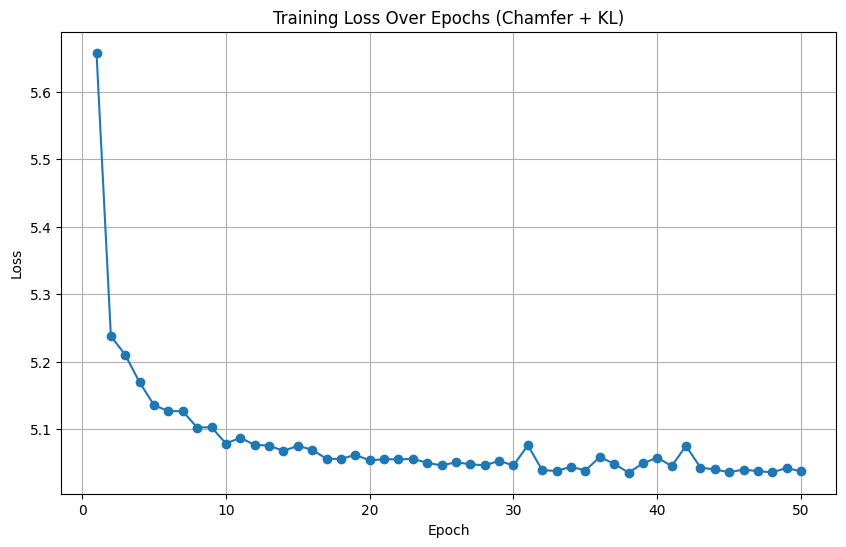

In [12]:
train_model(
    folder_path="/content/drive/MyDrive/buildings_pointcloud_ply",
    latent_dim=128,
    num_points=4096,
    batch_size=16,
    num_epochs=50,
    learning_rate=0.001,
    beta=3.0,
    device="cuda"  # or "cuda" if you have a GPU
)

Load the model and play around

In [1]:
import numpy as np
import open3d as o3d
import torch

def visualize_input_and_reconstructed(model, test_loader, device="cpu"):
    model.eval()

    with torch.no_grad():
        # Get the first batch from the test_loader
        for batch in test_loader:
            # Shape of batch: (batch_size, num_points, 3)
            batch = batch.to(device)
            break  # Just get the first batch

        # Let's visualize the first point cloud in this batch
        input_pc = batch[0]  # shape: (num_points, 3)
        input_np = input_pc.cpu().numpy()  # Convert to numpy for open3d

        # Encode and decode the point cloud
        mu, log_sigma = model.encoder(input_pc.unsqueeze(0))  # add batch dim => (1, num_points, 3)
        z = reparameterize(mu, log_sigma)
        reconstructed = model.decoder(z)  # shape: (1, num_points, 3)

        # Convert reconstructed to numpy
        reconstructed_np = reconstructed[0].cpu().numpy()

    # Create Open3D point cloud for the input
    pcd_input = o3d.geometry.PointCloud()
    pcd_input.points = o3d.utility.Vector3dVector(input_np)
    # Color the input cloud red
    pcd_input.paint_uniform_color([1.0, 0.0, 0.0])

    # Create Open3D point cloud for the reconstructed shape
    pcd_reconstructed = o3d.geometry.PointCloud()
    pcd_reconstructed.points = o3d.utility.Vector3dVector(reconstructed_np)
    # Color the reconstructed cloud green
    pcd_reconstructed.paint_uniform_color([0.0, 1.0, 0.0])

    # (Optional) Shift the reconstructed cloud so it’s easier to see side by side
    shift_along_x = 1.0
    pcd_reconstructed.translate((shift_along_x, 0, 0))

    # Visualize both point clouds together
    o3d.visualization.draw_geometries([pcd_input, pcd_reconstructed])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [15]:
import open3d as o3d
import torch

model = PointNetPPAutoencoder(latent_dim=128, num_points=4096)
model.load_state_dict(torch.load("pointnetpp_B3-VAE.pth", map_location=torch.device("cpu")))

model.to("cpu")  # or "cuda"

train_loader, test_loader = get_data_loaders(
    folder_path=r"C:\Users\Admin\PycharmProjects\AI-Projects\Tokyo-PointCloud\buildings_pointcloud_ply",
    num_points=4096,
    batch_size=4,  # or 1, if you want just one per batch
    train_ratio=0.9
)

visualize_input_and_reconstructed(model, test_loader, device="cpu")

C:\Users\Admin\AppData\Local\Temp\ipykernel_31396\2847674894.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("pointnetpp_B3-VAE.pth", ma

Dataset split: 3606 train samples, 401 test samples
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


C:\Users\Admin\AppData\Local\Temp\ipykernel_31396\1838968711.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('pointnetpp_B3-VAE.pth', m

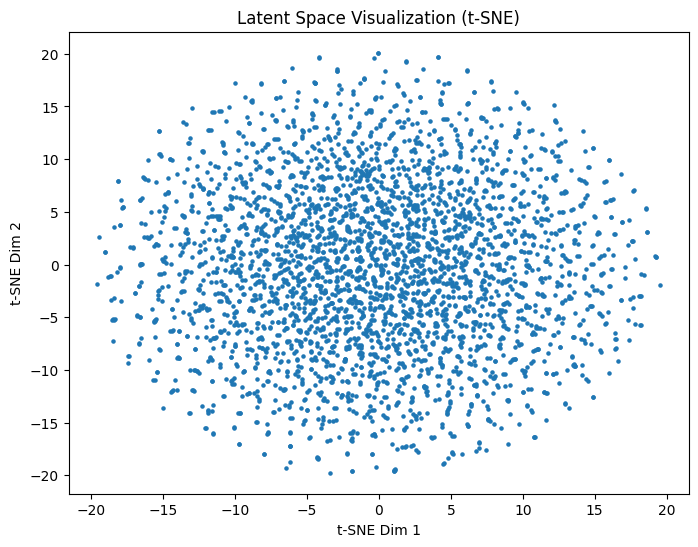

In [26]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# ---------------------------
# 1. Load your trained (beta-)VAE model
# ---------------------------

# Load model
model = PointNetPPAutoencoder(latent_dim=128, num_points=4096)
model.load_state_dict(torch.load('pointnetpp_B3-VAE.pth', map_location=torch.device('cpu')))
model.eval()

# ---------------------------
# 2. Prepare (or load) the dataset
# ---------------------------
# Assuming train_loader yields only `inputs`, which are point clouds.
all_latents = []

for inputs in train_loader:  # No labels
    inputs = inputs.to('cpu')  # Use 'cuda' if you have a GPU and the model is on GPU
    with torch.no_grad():
        z_mean, z_logvar = model.encoder(inputs)  # Call the encoder directly

        # Sample from Gaussian distribution using reparameterization trick
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std)  # Gaussian noise
        z_vec = z_mean + eps * std  # Sampled latent vector

    all_latents.append(z_vec.cpu().numpy())

all_latents = np.concatenate(all_latents, axis=0)  # shape: (N, latent_dim)

# ---------------------------
# 3. Apply t-SNE (or UMAP) to reduce dimensionality
# ---------------------------
tsne = TSNE(n_components=2, random_state=42)
latents_2d = tsne.fit_transform(all_latents)  # shape: (N, 2)

# ---------------------------
# 4. Plot the 2D t-SNE results
# ---------------------------
plt.figure(figsize=(8, 6))
plt.scatter(latents_2d[:, 0], latents_2d[:, 1], s=5)  # No labels, so just plot the points
plt.title("Latent Space Visualization (t-SNE)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()